<a href="https://colab.research.google.com/github/Lolo-17/DS-Unit-2-Linear-Models/blob/master/module2-regression-2/Regression_2_LS_DS_212_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 2*

---

# Regression 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [ ] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [ ] Engineer at least two new features. (See below for explanation & ideas.)
- [ ] Fit a linear regression model with at least two features.
- [ ] Get the model's coefficients and intercept.
- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Add your own stretch goal(s) !

# Importing

In [245]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [246]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv', 
                 parse_dates=['created'],
                 index_col='created')

assert df.shape == (49352, 33)

''' Renaming index to date and sorting by date '''
df.index.names = ['date']
df = df.sort_values(by='date')

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

In [247]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# EDA

In [248]:
print(df.shape)
df.head()

(48817, 33)


,bathrooms,bedrooms,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-04-01 22:12:41,1.0,1,X-LARGE Flex 1BR Loft! ~~ PRIME Greenwich Vill...,Astor Place,40.7302,-73.9924,3195,1 Astor Place,high,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-01 22:56:00,1.0,0,"This Enormous Studio Features: Harwood Floors,...",East 54th Street,40.7576,-73.9677,2000,230 East 54th Street,medium,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-01 22:57:15,2.0,3,--- East 31st St & Lexington Avenue --- This S...,East 31st St & Lexington Avenue,40.7388,-73.9851,5850,105 Lexington Avenue,high,1,1,0,1,1,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2016-04-01 23:26:07,1.0,1,Reduced Fee!! Priced To Rent!\rLarge Newly Upd...,West End Ave,40.7939,-73.9738,2745,700 West End Ave,medium,1,1,0,1,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2016-04-02 00:48:13,1.0,1,Phenomenal deal of the century!! This spacious...,E 88th street,40.7784,-73.9491,2400,401 E 88th street,medium,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [249]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48817 entries, 2016-04-01 22:12:41 to 2016-06-29 21:41:47
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bathrooms             48817 non-null  float64
 1   bedrooms              48817 non-null  int64  
 2   description           47392 non-null  object 
 3   display_address       48684 non-null  object 
 4   latitude              48817 non-null  float64
 5   longitude             48817 non-null  float64
 6   price                 48817 non-null  int64  
 7   street_address        48807 non-null  object 
 8   interest_level        48817 non-null  object 
 9   elevator              48817 non-null  int64  
 10  cats_allowed          48817 non-null  int64  
 11  hardwood_floors       48817 non-null  int64  
 12  dogs_allowed          48817 non-null  int64  
 13  doorman               48817 non-null  int64  
 14  dishwasher            48817 non-nul

In [250]:
df.index

DatetimeIndex(['2016-04-01 22:12:41', '2016-04-01 22:56:00',
               '2016-04-01 22:57:15', '2016-04-01 23:26:07',
               '2016-04-02 00:48:13', '2016-04-02 01:11:13',
               '2016-04-02 01:11:30', '2016-04-02 01:11:31',
               '2016-04-02 01:11:34', '2016-04-02 01:11:40',
               ...
               '2016-06-29 17:32:19', '2016-06-29 17:35:09',
               '2016-06-29 17:37:20', '2016-06-29 17:38:02',
               '2016-06-29 17:39:08', '2016-06-29 17:47:34',
               '2016-06-29 17:56:12', '2016-06-29 18:14:48',
               '2016-06-29 18:30:41', '2016-06-29 21:41:47'],
              dtype='datetime64[ns]', name='date', length=48817, freq=None)

In [251]:
# Checking the lenght of description.
df['description'].iloc[1]

'This Enormous Studio Features: Harwood Floors, HIGH Ceilings, LARGE Windows, Natural Light, FANTASTIC Closet Space, Updated Kitchen & Bathroom.\r\rGreat price! Laundry in Building and subway half a block away! Walk to work!\r\rEasy access to Murray Hill, Gramercy Park, Union Square Park, Midtown West, Chelsea, Meatpacking District, West Village & Much More...'

# Split Data

In [252]:
# Creating two new columsn for
# 1.) Bedroom + Bathrooms
# 2.) Description Lenght
df['bt_mas_bd'] = df['bathrooms'] + df['bedrooms']
df['descr_len'] = df['description'].str.len()
df['descr_len'] = df['descr_len'].replace(np.nan,0)

In [236]:
# Using price as my target.
# Using 2 features, see below for X.
y = df['price']
X = df[['bt_mas_bd', 'descr_len']]

# Using April and May of 2016 to train.
# Using June of 2016 to test.
am_spl = X.index < '2016-06'
jn_spl = X.index > '2016-06'
X_train, y_train = X.loc[am_spl], y.loc[am_spl]
X_val, y_val = X.loc[jn_spl], y.loc[jn_spl]

# An if statement to check if I got
# all entries in the dataframe when splitting.
if len(X_train) + len(X_val) == 48817:
  print('Split succesful')
else:
  print('Check again')

Split succesful


# Establishing Baseline

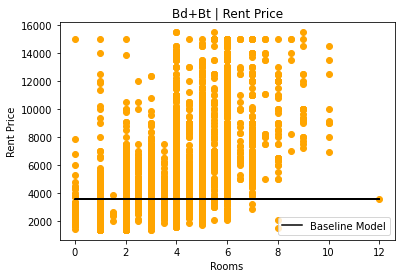

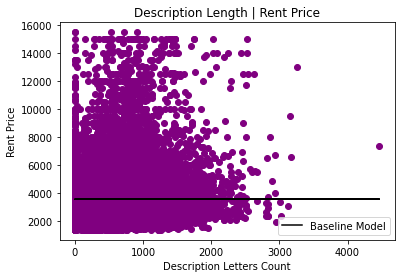

In [265]:
ft_1 = 'bt_mas_bd'
ft_2 = 'descr_len'

y_pred_0 = [y_train.mean()]*len(X_train)

plt.scatter(X_train[ft_1], y_train, color='orange')
plt.plot(X_train[ft_1], 
         y_pred_0, 
         color='black', 
         label='Baseline Model')
plt.title('Bd+Bt | Rent Price')
plt.xlabel('Rooms')
plt.ylabel('Rent Price')
plt.legend()
plt.legend(loc="best")
plt.show()

print('\n')

plt.scatter(X_train[ft_2], y_train, color='purple')
plt.plot(X_train[ft_2], 
         y_pred_0, 
         color='black', 
         label='Baseline Model')
plt.title('Description Length | Rent Price')
plt.xlabel('Description Letters Count')
plt.ylabel('Rent Price')
plt.legend()
plt.legend(loc="lower right")
plt.show()

In [272]:
print('y training mean:', round(y_train.mean()))
print('Baseline MAE:', round(mean_absolute_error(y_train, y_pred)))

y training mean: 3576
Baseline MAE: 1191.0


# Build Model

In [270]:
# Building models for
# bd+bt and description length.

# 1. Instantiate your model
# bedrooms + bathrooms
model_ft1 = LinearRegression()
# description length
model_ft2 = LinearRegression()

# 2. Fit model to data
model_ft1.fit(X_train[[ft_1]], y_train)
model_ft2.fit(X_train[[ft_2]], y_train)

# 3. Make predictions
y_pred_1 = model_ft1.predict(X_train[[ft_1]])
y_pred_2 = model_ft2.predict(X_train[[ft_2]])

FEATURE #1


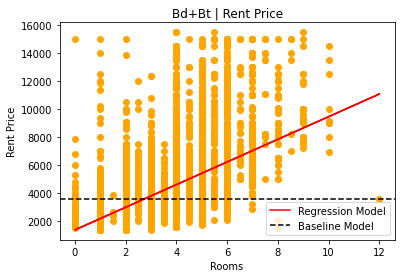



FEATURE #2


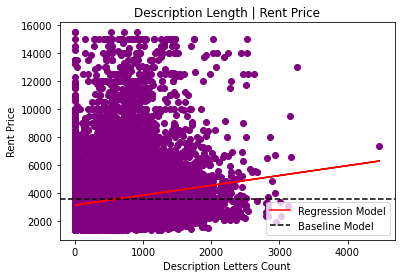

In [271]:
print("FEATURE #1")
plt.scatter(X_train[ft_1], y_train, color='orange')
plt.plot(X_train[ft_1], 
         y_pred_1, 
         color='red',
         label='Regression Model')
plt.axhline(y_train.mean(),
         color='black', 
         label='Baseline Model',
         linestyle='--')
plt.title('Bd+Bt | Rent Price')
plt.xlabel('Rooms')
plt.ylabel('Rent Price')
plt.legend()
plt.legend(loc="best")
plt.show()

print('\n')

print("FEATURE #2")
plt.scatter(X_train[ft_2], y_train, color='purple')
plt.plot(X_train[ft_2], 
         y_pred_2, 
         color='red',
         label='Regression Model')
plt.axhline(y_train.mean(),
         color='black', 
         label='Baseline Model',
         linestyle='--')
plt.title('Description Length | Rent Price')
plt.xlabel('Description Letters Count')
plt.ylabel('Rent Price')
plt.legend()
plt.legend(loc="lower right")
plt.show()

# Check Metrics

In [318]:
# Mean Absolute Errors for
# both of my features.
print('Feature #1 Training MAE:', round(mean_absolute_error(y_train, model_ft1.predict(X_train[[ft_1]]))))
print(f'Feature #1 Validation MAE: {round(mean_absolute_error(y_val, model_ft1.predict(X_val[[ft_1]])))} \n')
print('Feature #2 Training MAE:', round(mean_absolute_error(y_train, model_ft2.predict(X_train[[ft_2]]))))
print('Feature #2 Validation MAE:', round(mean_absolute_error(y_val, model_ft2.predict(X_val[[ft_2]]))))

Feature #1 Training MAE: 894.0
Feature #1 Validation MAE: 911.0 

Feature #2 Training MAE: 1191.0
Feature #2 Validation MAE: 1179.0


In [311]:
# Linear Regression Formulas
# for both features.
print('Bathrooms+Bedrooms')
print(f'Rent Price = {round(model_ft1.intercept_)} + {round(model_ft1.coef_[0])} x Bt+Bd \n')
print('Description Lenght')
print(f'Rent Price = {round(model_ft2.intercept_)} + {round(model_ft2.coef_[0])} x Descrip Len')

Bathrooms+Bedrooms
Rent Price = 1363.0 + 810.0 x Bt+Bd 

Description Lenght
Rent Price = 3147.0 + 1.0 x Descrip Len


In [290]:
# These two functions calculates the
# predicted input number of Bt+Bd and
# description length to get rent price.

# Calculates Bt+Bd to get rent price.
def Bt_Bd(number):
  print(f'You selected {number} Bt+Bd room(s), so your rent price is, {round(model_ft1.intercept_)+round(model_ft1.coef_[0])*number}')

# Calculates description length to get rent price.
def des_len(number):
  print(f'You selected {number} description letters len, so your rent price is, {round(model_ft2.intercept_)+round(model_ft2.coef_[0])*number}')

# Testing and showing functions
Bt_Bd(5)
des_len(6000)

You selected 5 Bt+Bd room(s), so your rent price is, 5413.0
You selected 6000 description letters len, so your rent price is, 9147.0


# Root Mean Squared Error

In [314]:
# Root Mean Squared Error for
# both of my features.
print('Feature #1 Training RMSE:', round(mean_squared_error(y_train, model_ft1.predict(X_train[[ft_1]]), squared=False)))
print(f'Feature #1 Validation RMSE: {round(mean_squared_error(y_val, model_ft1.predict(X_val[[ft_1]]), squared=False))} \n')
print('Feature #2 Training RMSE:', round(mean_squared_error(y_train, model_ft2.predict(X_train[[ft_2]]), squared=False)))
print('Feature #2 Validation RMSE:', round(mean_squared_error(y_val, model_ft2.predict(X_val[[ft_2]]), squared=False)))

Feature #1 Training RMSE: 1341.0
Feature #1 Validation RMSE: 1340.0 

Feature #2 Training RMSE: 1740.0
Feature #2 Validation RMSE: 1737.0


# $R^2$

In [315]:
# R square for both of my features.
print('Feature #1 Training R2:', model_ft1.score(X_train[[ft_1]], y_train))
print(f'Feature #1 Validation R2: {model_ft1.score(X_val[[ft_1]], y_val)} \n')
print('Feature #2 Training R2:', model_ft2.score(X_train[[ft_2]], y_train))
print('Feature #2 Validation R2:', model_ft2.score(X_val[[ft_2]], y_val))

Feature #1 Training R2: 0.42093000521396107
Feature #1 Validation R2: 0.4220517161864744 

Feature #2 Training R2: 0.024774646065977124
Feature #2 Validation R2: 0.02879125690693851
